#Case Study 2: Titanic Dataset

##Business Case

The business case for predicting survival on the Titanic revolves around maximizing rescue efforts and minimizing casualties during a disaster scenario. The primary goal is to accurately identify survivors to ensure their timely rescue, while also minimizing false alarms and unnecessary rescue efforts. Therefore, the key objective is to develop a predictive model that can effectively mark the survivors and minimizes incorrectly flagging deceased passengers as survived.

For this, we will look at the accuracy, as well as the precision and the specificity.

##Importing packages and the dataset

In [1]:
import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

# Ignore all warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the Titanic dataset
titanic = sns.load_dataset('titanic')
# Print the first few rows of the dataset
titanic.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


| Variable   | Definition               | Key                                      |
|------------|--------------------------|------------------------------------------|
| Survived   | Survival                 | 0 = No, 1 = Yes                          |
| Pclass     | Ticket class             | 1 = 1st, 2 = 2nd, 3 = 3rd               |
| Sex        | Gender                   | Male, Female                             |
| Age        | Age in years             |                                          |
| SibSp      | # of siblings / spouses aboard the Titanic |                                  |
| Parch      | # of parents / children aboard the Titanic |                                   |
| Fare       | Passenger fare           |                                          |
| Embarked   | Port of Embarkation      | Cherbourg, Queenstown, Southampton      |
| Class      | Class                    | First, Second, Third                     |
| Who        | Who                      | Man, Woman, Child                        |
| Adult_male | Adult male               | True, False                              |
| Deck       | Deck                     | A, B, C, D, E, F, G                      |
| Embark_town| Town of embarkation      | Cherbourg, Queenstown, Southampton      |
| Alive      | Alive                    | yes, no                                  |
| Alone      | Alone                    | True, False                              |


##EDA

> Now that we have loaded the data, we will now check for consistency and perform an EDA.

1. Check Data Types: Ensure that the data types of each column make sense for the type of data they contain.

2. Check Unique Values: For categorical variables, examine the unique values to identify any unexpected or inconsistent entries. This helps ensure that the categories are well-defined and consistent throughout the dataset.

3. Look for Missing Values: Check for missing values in the dataset. Missing values can indicate inconsistencies in data collection or entry. Depending on the analysis, we may need to decide how to handle missing values, either by imputing them with appropriate values or removing them.

4. Deleting Duplicate Rows: Delete all duplicate rows that do not add value to the dataset or introduce skewness and bias.

5. Examine Range and Distribution: For numeric variables, examine their range and distribution. Look for outliers or unusual values that may indicate data entry errors or inconsistencies. Histograms, boxplots, or summary statistics can help in this analysis.


In [3]:
# Convert to DataFrame
df = pd.DataFrame(titanic)

In [4]:
# Display descriptive statistics for the DataFrame
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- **Survived:**
  - Mean survival rate: 38.4%
  - Majority of passengers did not survive (25th percentile: 0, median: 0, 75th percentile: 1)

- **Pclass:**
  - Majority of passengers were in lower classes (median: 3)
  - Standard deviation indicates some variation in class distribution

- **Age:**
  - Average age of passengers: 29.7 years
  - Significant variation in ages (standard deviation: 14.5 years)
  - Some passengers were infants (minimum age: 0.42 years) while others were elderly (maximum age: 80 years)

- **Sibsp (Number of Siblings/Spouses Aboard):**
  - Most passengers traveled alone (25th and 50th percentiles: 0)
  - Some passengers had up to 8 siblings or spouses aboard

- **Parch (Number of Parents/Children Aboard):**
  - Majority of passengers traveled without parents or children (75th percentile: 0)
  - Some passengers had up to 6 parents or children aboard

- **Fare:**
  - Mean fare: $32.20
  - Significant variation in fare prices (standard deviation: $49.69)
  - Some passengers traveled for free (minimum fare: $0) while others paid as much as $512.33




In [5]:
# Display the shape of the DataFrame
df.shape

(891, 15)

The dataframe has 891 records or observations, and each record has 15 different attributes or features.

###Check Datatypes

In [6]:
# Display the data types of each column in the DataFrame
df.dtypes

survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object

1. `survived`: This column represents whether a passenger survived the Titanic disaster. It is of type `int64`, where 1 indicates the passenger survived and 0 indicates the passenger did not survive.

2. `pclass`: This column represents the passenger class, indicating the socio-economic status of the passenger. It is of type `int64`, with values 1, 2, and 3 representing first, second, and third class, respectively.

3. `sex`: This column represents the gender of the passenger. It is of type `object`, containing strings such as "male" and "female".

4. `age`: This column represents the age of the passenger. It is of type `float64`, containing floating-point numbers.

5. `sibsp`: This column represents the number of siblings or spouses aboard the Titanic for each passenger. It is of type `int64`.

6. `parch`: This column represents the number of parents or children aboard the Titanic for each passenger. It is of type `int64`.

7. `fare`: This column represents the fare paid by each passenger for their ticket. It is of type `float64`.

8. `embarked`: This column represents the port of embarkation for each passenger. It is of type `object`, containing strings such as "C" for Cherbourg, "S" for Southampton, and "Q" for Queenstown.

9. `class`: This column is a categorical version of `pclass`, representing the passenger class as a category data type.

10. `who`: This column represents a categorical variable describing the passenger as either "man", "woman", or "child". It is of type `object`.

11. `adult_male`: This column represents whether the passenger is an adult male. It is of type `bool`, with `True` indicating the passenger is an adult male.

12. `deck`: This column represents the deck where the passenger's cabin was located. It is of type `category`.

13. `embark_town`: This column represents the town or city where the passenger embarked. It is of type `object`.

14. `alive`: This column indicates whether the passenger survived the disaster. It is of type `object`, containing strings such as "yes" and "no".

15. `alone`: This column indicates whether the passenger was traveling alone. It is of type `bool`, with `True` indicating the passenger was alone.


In [7]:
# Drop unnecessary columns
df.drop('deck', axis=1, inplace=True)      # Drop the 'deck' column
df.drop('alive', axis=1, inplace=True)     # Drop the 'alive' column
df.drop('class', axis=1, inplace=True)     # Drop the 'class' column
df.drop('embarked', axis=1, inplace=True)  # Drop the 'embarked' column

# Convert selected columns to categorical data type
df['survived'] = df['survived'].astype('category')    # Convert 'survived' column to categorical
df['sex'] = df['sex'].astype('category')              # Convert 'sex' column to categorical
df['who'] = df['who'].astype('category')              # Convert 'who' column to categorical
df['adult_male'] = df['adult_male'].astype('category')# Convert 'adult_male' column to categorical
df['alone'] = df['alone'].astype('category')          # Convert 'alone' column to categorical
df['embark_town'] = df['embark_town'].astype('category')# Convert 'embark_town' column to categorical
df['pclass'] = df['pclass'].astype('category')        # Convert 'pclass' column to categorical

In [8]:
# Print the data types of each column in the DataFrame
print("Data types of each column:")
print(df.dtypes)

Data types of each column:
survived       category
pclass         category
sex            category
age             float64
sibsp             int64
parch             int64
fare            float64
who            category
adult_male     category
embark_town    category
alone          category
dtype: object


The Deck column can be dropped for 2 reasons:
1. There is a significant amount of missing values, rendering the column meaningless.
2. The column will not be used in the EDA and regression later.

- Deleting the 'alive' Column
The 'alive', 'class', and 'embarked' columns were removed from the DataFrame using the `drop()` method. This column was deleted because it contains redundant information compared to the 'survived' and 'pclass' columns. Both columns likely represent the same information but in reverse (e.g., 'alive' might contain "yes" for survived passengers and "no" for non-survived passengers), making the 'alive' column redundant and unnecessary for analysis. Same for the 'class', and 'embarked' columns.

- Converting Columns to Categorical Data Types
Several columns in the DataFrame were converted to categorical data types using the `astype()` method. Categorical data types are suitable for columns with a fixed number of unique values or categories.

> The 'survived', 'sex', 'who', 'embark_town', and 'pclass' columns were converted to categorical data types. This conversion optimizes memory usage and allows for efficient analysis of these categorical variables.

These modifications help streamline the DataFrame by removing redundant information and optimizing data types for efficient analysis.


###Checking for Unique Values

In [9]:
# Check unique values for each categorical column
categorical_columns = ['survived', 'pclass', 'sex', 'who', 'adult_male', 'embark_town', 'alone']

for column in categorical_columns:
    unique_values = df[column].unique()
    print(f"Unique values for column '{column}': {unique_values}")


Unique values for column 'survived': [0, 1]
Categories (2, int64): [0, 1]
Unique values for column 'pclass': [3, 1, 2]
Categories (3, int64): [1, 2, 3]
Unique values for column 'sex': ['male', 'female']
Categories (2, object): ['female', 'male']
Unique values for column 'who': ['man', 'woman', 'child']
Categories (3, object): ['child', 'man', 'woman']
Unique values for column 'adult_male': [True, False]
Categories (2, bool): [False, True]
Unique values for column 'embark_town': ['Southampton', 'Cherbourg', 'Queenstown', NaN]
Categories (3, object): ['Cherbourg', 'Queenstown', 'Southampton']
Unique values for column 'alone': [False, True]
Categories (2, bool): [False, True]


The unique values for each categorical column appear to be appropriate and consistent, except for the "embark_town" column which has some missing values indicated by "NaN". Let's break down the findings:

- **Survived:** The unique values are 0 and 1, representing whether a passenger did not survive (0) or survived (1), which is consistent with expectations.

- **Pclass:** The unique values are 1, 2, and 3, representing the three passenger classes: First class, Second class, and Third class, respectively.

- **Sex:** The unique values are 'male' and 'female', indicating the gender of passengers.

- **Who:** The unique values are 'man', 'woman', and 'child', representing different categories of passengers based on age and gender.

- **Adult Male:** The unique values are True and False, indicating whether a passenger is categorized as an adult male or not.

- **Embark Town:** The unique values are 'Southampton', 'Cherbourg', and 'Queenstown', indicating the towns where passengers embarked. However, there are some missing values represented by "NaN".

- **Alone:** The unique values are True and False, indicating whether a passenger traveled alone or not.

Overall, the unique values appear to be reasonable and consistent with expectations for each categorical column, except for the presence of missing values in the "embark_town" column, which may need to be addressed during data preprocessing.


###Handling Missing Values



In [10]:
# Count missing values in each column of the DataFrame
missing_values = df.isna().sum()

# Print the count of missing values in each column
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
who              0
adult_male       0
embark_town      2
alone            0
dtype: int64


- Analysis of Missing Values

The dataset contains missing values in several columns. Here's a breakdown of columns with missing values:

| Column       | Missing Values | Percentage of Total |
|--------------|----------------|---------------------|
| age          | 177            | 19.87%              |
| embark_town  | 2              | 0.22%               |

> Observations:
- **Age**: Missing values are present in the "age" column for 177 passengers, accounting for approximately 19.87% of the total dataset. This could indicate that age information was not available for these passengers.
- **Embark_town**: Similar to the "embarked" column, the "embark_town" column also has 2 missing values (0.22% of the dataset). These missing values might be related to the missing "embarked" values, as they represent the town or city where the passenger embarked.

In [11]:
# Impute missing values in the 'age' column with the mean
df['age'].fillna(df['age'].mean(), inplace=True)

# Impute missing values in the 'embark_town' column with the mode
imputer = SimpleImputer(strategy='most_frequent')
df['embark_town'] = imputer.fit_transform(df[['embark_town']])

In [12]:
# Check for missing values in each column after imputation
missing_values_after_imputation = df.isna().sum()

# Print the count of missing values in each column
print("Missing values in each column after imputation:")
print(missing_values_after_imputation)

Missing values in each column after imputation:
survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
who            0
adult_male     0
embark_town    0
alone          0
dtype: int64


After imputing the missing data, there is no more missing data.

###Deleting Duplicates

In [13]:
# Check for duplicate rows in the DataFrame
duplicate_rows = df.duplicated()

# Sum the number of duplicate rows
num_duplicates = duplicate_rows.sum()

# Print the total number of duplicate rows
print("Total number of duplicate rows:", num_duplicates)

Total number of duplicate rows: 111


The dataset contains 111 duplicates. These will be removed in the next step.

In [14]:
# Remove duplicate rows from the DataFrame
df = df.drop_duplicates()

# Verify the shape of the DataFrame after removing duplicates
print("DataFrame shape after removing duplicates:", df.shape)

DataFrame shape after removing duplicates: (780, 11)


In [15]:
# Check for duplicate rows in the DataFrame after removing duplicates
num_remaining_duplicates = df.duplicated().sum()

# Print the number of remaining duplicate rows
print("Number of remaining duplicate rows:", num_remaining_duplicates)

Number of remaining duplicate rows: 0


Right now, there are no more duplicates in the dataset.

In [16]:
# Print the shape of the DataFrame
print("DataFrame shape:", df.shape)

DataFrame shape: (780, 11)


After deleting the duplicates, the shape of the DataFrame is (780, 11). This means that the DataFrame now contains 780 rows and 11 columns.

> Changes Made:
1. **Converted to Categorical Variables**: Numeric columns that represent categorical variables have been converted to categorical data type using pandas' `astype()` method.
   
2. **Imputation of Missing Values**: Missing values were treated by either imputation or deleting the column.
   - For numerical data (e.g., 'age'), missing values were imputed with the mean.
   - For categorical data (e.g., 'embarked', 'embark_town'), missing values were imputed with the mode.
   - Columns with missing values were either imputed or deleted based on the data processing strategy.

5. **Duplicates Removed**: Duplicate rows were deleted from the dataset to ensure data integrity and eliminate redundant information.

> New Dataset Columns:
The processed dataset now has the following columns:
- `survived`: Category type indicating survival status.
- `pclass`: Category type representing passenger class.
- `sex`: Category type representing gender.
- `age`: Float64 representing age.
- `sibsp`: Integer representing the number of siblings or spouses aboard.
- `parch`: Integer representing the number of parents or children aboard.
- `fare`: Float64 representing the fare paid.
- `who`: Category type representing a categorical variable describing the passenger.
- `adult_male`: Boolean type representing whether the passenger is an adult male.
- `embark_town`: Category type representing the town or city where the passenger embarked.
- `alone`: Boolean type representing whether the passenger was traveling alone.

These modifications ensure the dataset is properly formatted and ready for further analysis or modeling.




###Univariate Analysis

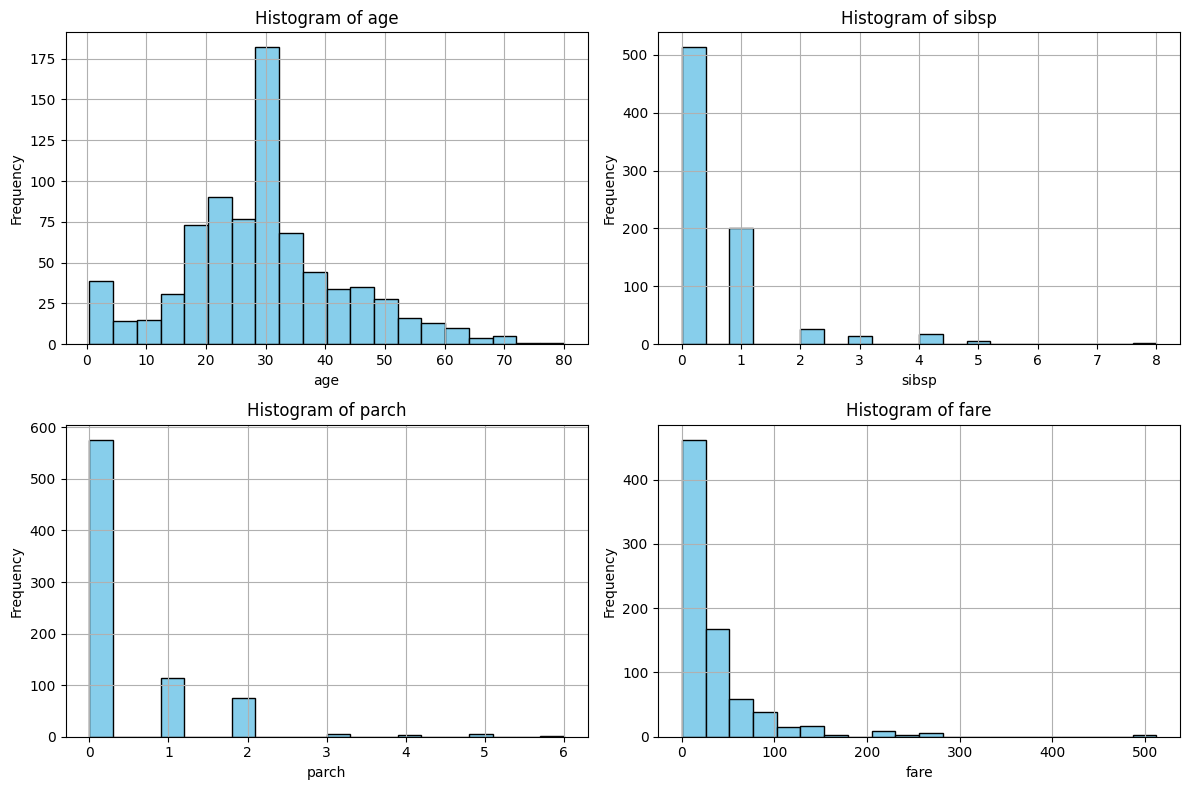

In [17]:
# Select numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

# Define number of rows and columns for subplots
num_rows = (numeric_columns.shape[1] + 1) // 2
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Flatten axes if necessary
axes = axes.flatten()

# Plot histograms for each numeric column
for i, column in enumerate(numeric_columns.columns):
    ax = axes[i]
    ax.hist(df[column], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

- The majority of the data follows a normal distribution, albeit with right skew.
- Age appears to be normally distributed, while the counts of siblings and parents are skewed towards lower values, with notable outliers towards higher values.
- Fare prices are predominantly clustered between 0-100 dollars, although some outliers skew the histogram towards higher values.


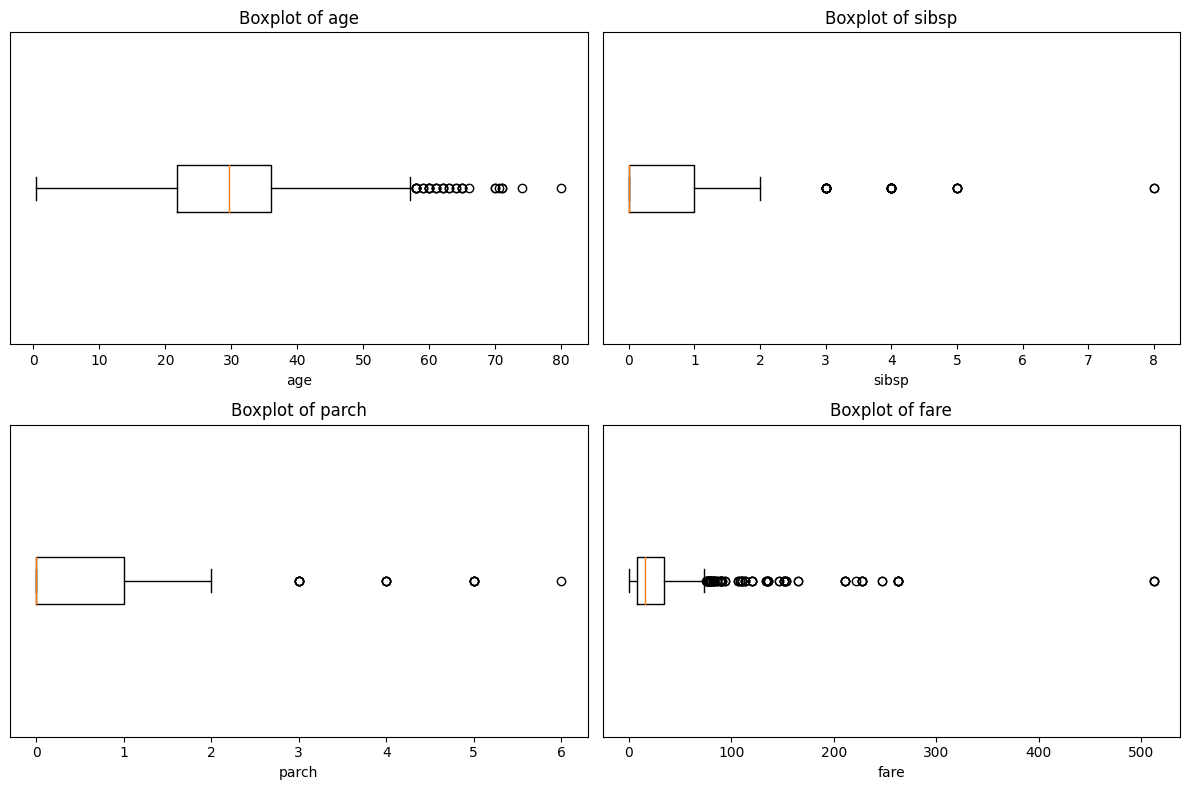

In [18]:
import matplotlib.pyplot as plt

# Select numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int64'])

# Define number of rows and columns for subplots
num_rows = (numeric_columns.shape[1] + 1) // 2
num_cols = 2

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Flatten axes if necessary
axes = axes.flatten()

# Plot boxplots for each numeric column
for i, column in enumerate(numeric_columns.columns):
    ax = axes[i]

    # Plot boxplot
    ax.boxplot(df[column], vert=False)
    ax.set_title(f'Boxplot of {column}')
    ax.set_xlabel(column)
    ax.yaxis.set_visible(False)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


The boxplots reveal that the numerical features exhibit right skewness, and each feature displays several outliers. We intend to address these issues in our subsequent analysis.

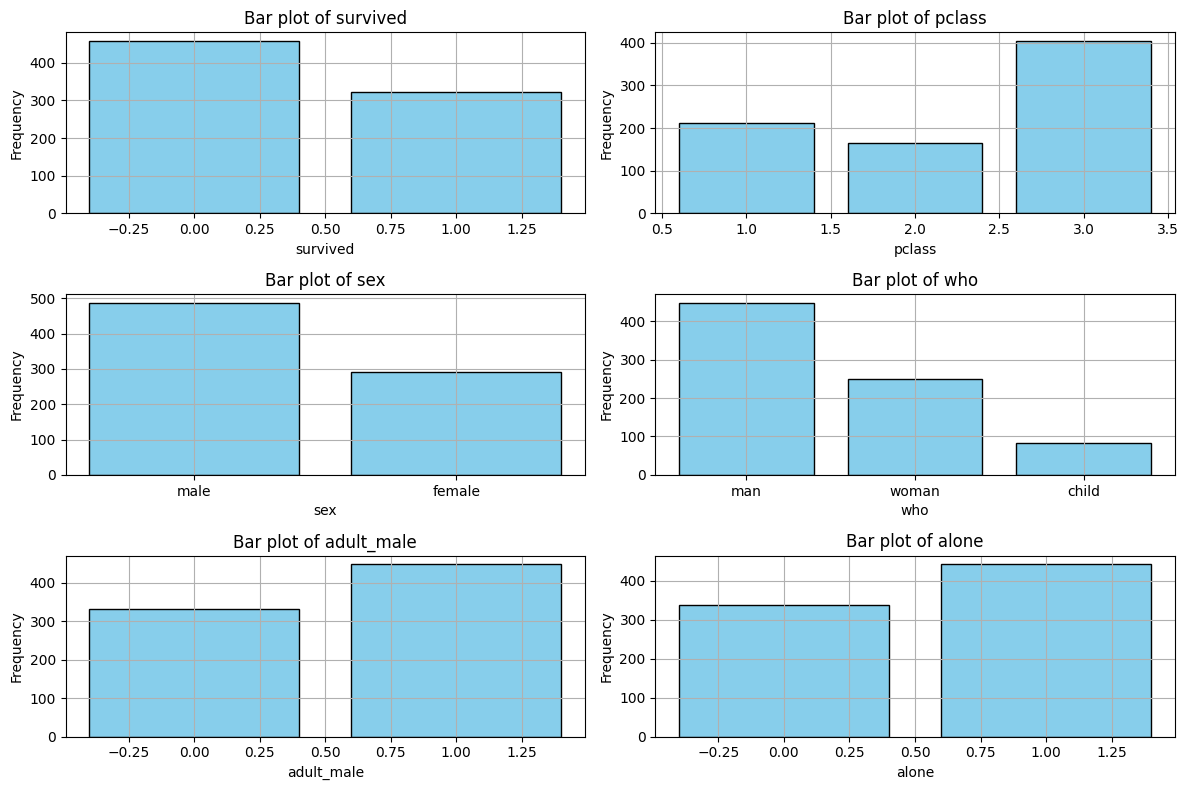

In [19]:
# Select categorical columns
categorical_columns = df.select_dtypes(include=['category', 'bool'])

# Determine the number of rows and columns for subplots
num_plots = categorical_columns.shape[1]
num_rows = (num_plots + 1) // 2
num_cols = 2 if num_plots > 1 else 1

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

# Flatten axes if necessary
axes = axes.flatten()

# Plot bar plots for each categorical column
for i, column in enumerate(categorical_columns.columns):
    ax = axes[i]
    category_counts = df[column].value_counts()
    ax.bar(category_counts.index, category_counts.values, color='skyblue', edgecolor='black')
    ax.set_title(f'Bar plot of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Hide the empty subplot if there's an odd number of plots
if num_plots % 2 != 0:
    fig.delaxes(axes[-1])

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

- The number of casualties exceeded the count of survivors.
- The largest proportion of passengers belonged to the third class, while the second class had the fewest occupants.
- Male passengers outnumbered female passengers.
- The majority of passengers were adult males, with relatively fewer children on board.
- Collectively, the count of adult males exceeded the combined count of females and children.
- Most passengers embarked at Southampton, while the least embarked at Queenstown.
- The majority of passengers traveled alone.

###Bivariate Analysis

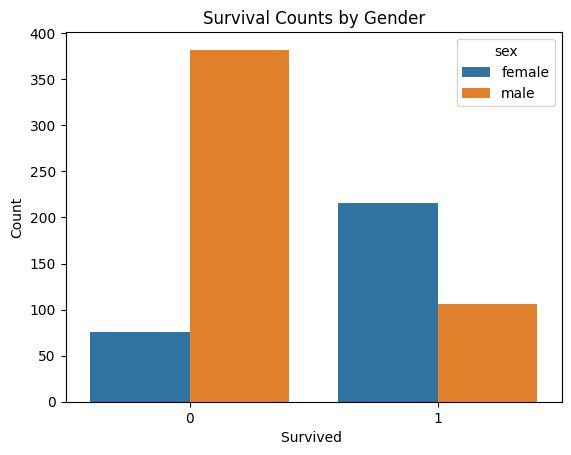

In [20]:
# Plotting survival counts based on gender
sns.countplot(x='survived', hue='sex', data=df)

# Adding title and labels
plt.title('Survival Counts by Gender')
plt.xlabel('Survived ')
plt.ylabel('Count')

plt.show()

From this graph, we can see that the difference between male and female casualties is very big. There were more than 5 times the amount of deaths among men than women. There were also more women that survived the disaster than men. This is probably due to the fact that they put the women on the rescue boats first.

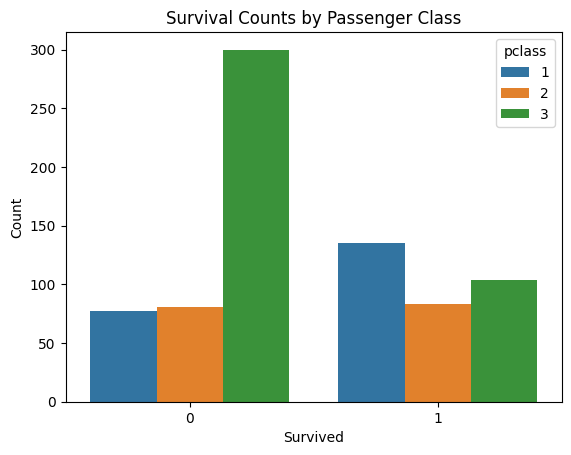

In [21]:
# Plotting survival counts based on passenger class
sns.countplot(x='survived', hue='pclass', data=df)

# Adding title and labels
plt.title('Survival Counts by Passenger Class')
plt.xlabel('Survived')
plt.ylabel('Count')

plt.show()

What we can see from this graph is that among the people that did not survive the disaster, the prevalent majority was from 3rd class tickets. This indicates that the people with more expensive tickets were prioritized.

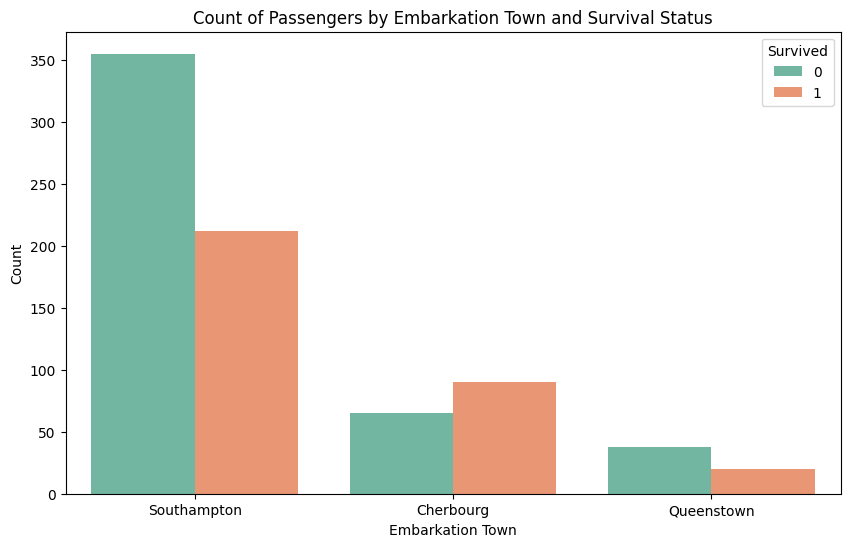

In [22]:
# Create bar plot
plt.figure(figsize=(10, 6))
sns.countplot(x='embark_town', hue='survived', data=df, palette='Set2')
plt.title('Count of Passengers by Embarkation Town and Survival Status')
plt.xlabel('Embarkation Town')
plt.ylabel('Count')
plt.legend(title='Survived')
plt.show()

From this plot, we observe that a significant proportion of deceased individuals originated from Southampton, which aligns with the fact that the highest number of passengers embarked from this location. However, what's intriguing is the survival pattern among passengers from Cherbourg, where the majority managed to survive despite their smaller numbers compared to Southampton.

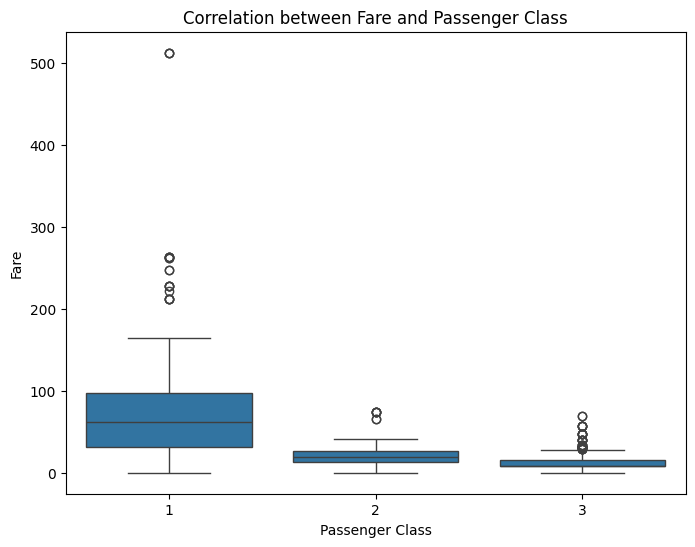

In [23]:
# Plot the correlation between 'fare' and 'pclass'
plt.figure(figsize=(8, 6))
sns.boxplot(x='pclass', y='fare', data=df)
plt.title('Correlation between Fare and Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Fare')
plt.show()

As anticipated, the fare prices noticeably varied among ticket classes, with first-class tickets exhibiting significantly higher prices compared to those of second or third class. The disparity between second and third class fares appears to be minimal, suggesting a potential overlap during the modeling phase between these two classes.

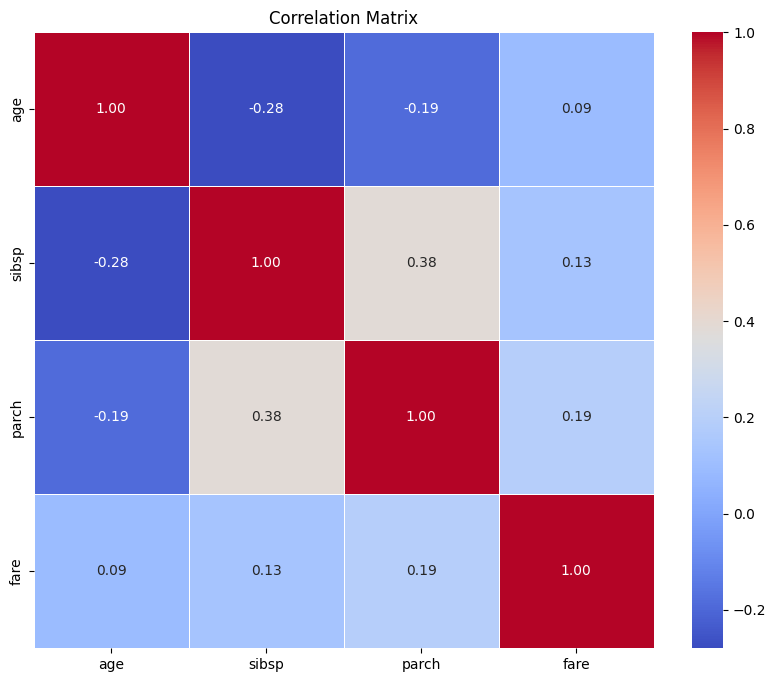

In [24]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

> Correlation Matrix Findings

1. **Positive Correlation between Fare and Number of Parents/Children (parch):**
   - There is a positive correlation of approximately 0.19 between the fare paid and the number of parents or children aboard (parch).
   - **Finding:** This suggests that passengers who paid higher fares were more likely to be traveling with family members, such as parents or children. Higher fare tickets might have been purchased for larger cabins or accommodations suitable for families.

2. **Negative Correlation between Age and Number of Siblings/Spouses (sibsp):**
   - There is a negative correlation of approximately -0.28 between age and the number of siblings or spouses aboard (sibsp).
   - **Finding:** This indicates that older passengers tended to travel with fewer siblings or spouses. It's possible that older passengers were more likely to be traveling alone or with their adult children, rather than siblings or spouses.

3. **Other Correlation:**
   - There is a weak positive correlation of approximately 0.09 between age and fare.
   - **Finding:** Although the correlation between age and fare is positive, it is relatively weak. This suggests that there is no strong relationship between the age of passengers and the fare they paid. Other factors, such as passenger class or cabin accommodations, may have had a greater influence on fare prices.


###Multivariate Analysis

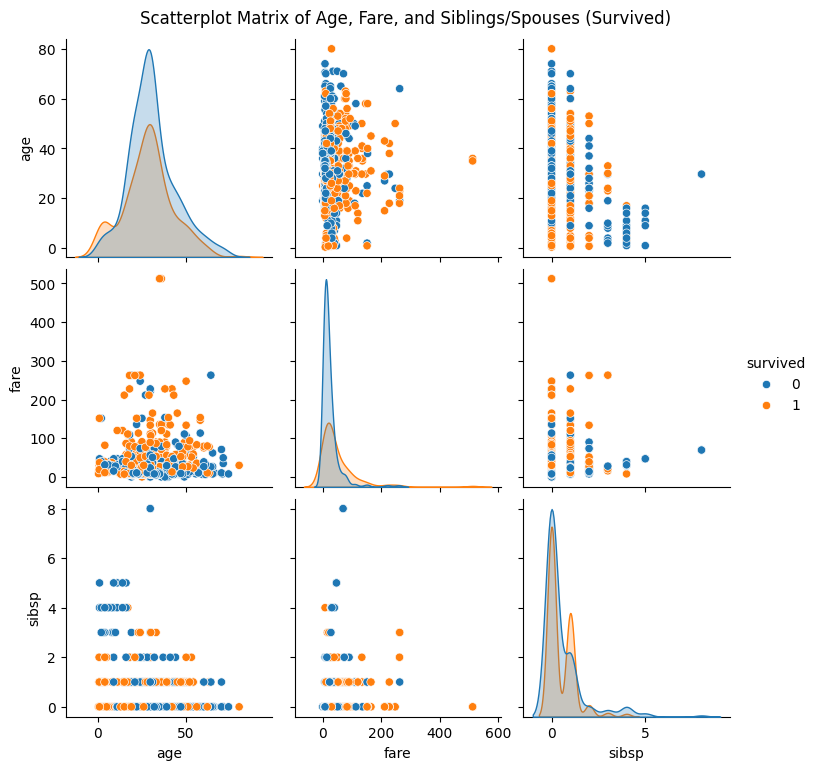

In [25]:
# Selecting variables and creating scatterplot matrix
scatterplot = sns.pairplot(data=df, vars=['age', 'fare', 'sibsp'], hue='survived')
scatterplot.fig.suptitle('Scatterplot Matrix of Age, Fare, and Siblings/Spouses (Survived)', y=1.02)
plt.show()

Upon analyzing the pairplot, we observe a comprehensive overview of our initial distributions presented in a correlation matrix format. A key observation is the relatively low correlations between the features, indicating a lack of strong linear relationships among them. Despite the absence of prominent correlations with survival rate, we can glean valuable insights from the plot.

- **Survival Trends**: While correlations with survival rate may be elusive, a discernible trend emerges regarding fare and survival. Individuals who paid higher fares appear to have a better chance of survival. This observation suggests a potential association between socioeconomic status, as indicated by fare prices, and survival outcomes. Passengers with higher fares may have had access to better accommodations or resources, enhancing their chances of survival during the disaster.

- **Lack of Correlation between Fare and Age**: Conversely, we find no clear relationship between fare and age. Despite the apparent clustering of fare values, there is no evident trend linking fare prices with passenger age. This lack of correlation implies that fare prices were not influenced significantly by passenger age, highlighting the complexity of factors contributing to fare determination.

In summary, while the pairplot does not reveal strong correlations between features and survival rate, it offers valuable insights into potential relationships between fare prices, age, and survival outcomes. These insights underscore the multifaceted nature of the Titanic dataset and the nuanced factors influencing passenger survival during the tragic event.


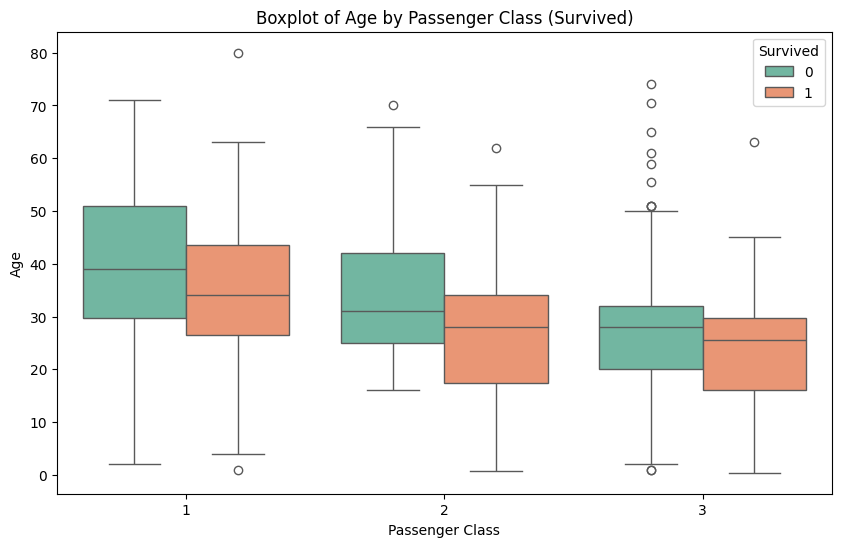

In [26]:
# Creating boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='pclass', y='age', hue='survived', data=df, palette='Set2')
plt.title('Boxplot of Age by Passenger Class (Survived)')
plt.xlabel('Passenger Class')
plt.ylabel('Age')
plt.legend(title='Survived', loc='upper right')
plt.show()

Upon examination of this plot, it becomes apparent that the average age within each passenger class tends to be lower for survivors compared to non-survivors. This observation suggests a potential correlation between age and survival outcomes, wherein younger individuals may have had a higher likelihood of surviving the disaster.

However, it's important to note that this plot solely represents the average age within each passenger class and does not provide information about the count of individuals. While it hints at a possible relationship between age, passenger class, and survival, a more comprehensive analysis is required to validate this hypothesis.

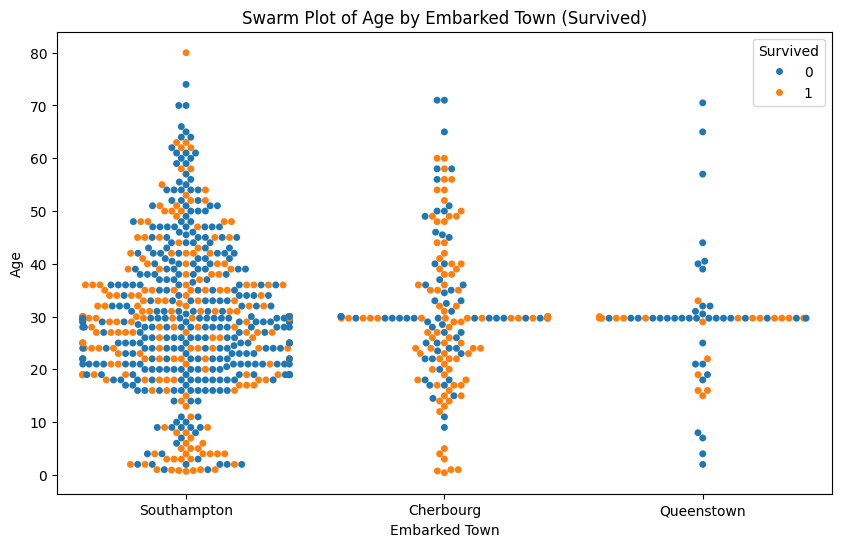

In [27]:
# Create swarm plot
plt.figure(figsize=(10, 6))
sns.swarmplot(x='embark_town', y='age', hue='survived', data=df)
plt.title('Swarm Plot of Age by Embarked Town (Survived)')
plt.xlabel('Embarked Town')
plt.ylabel('Age')
plt.legend(title='Survived')
plt.show()

Upon inspecting the swarmplot, several discernible patterns emerge:

- **Age Distribution**: The plot reveals that the largest concentration of individuals falls around the age of 30, suggesting that a significant portion of passengers were in their thirties. This age range appears to be the most common among those onboard.

- **Embarkation Town**: Another notable observation is the predominance of passengers embarking from Southampton. The swarmplot illustrates that a substantial number of individuals boarded the ship from Southampton compared to other embarkation towns, indicating Southampton as the primary point of departure for the majority of passengers.

- **Correlation between Embarkation Town and Age**: However, attempting to establish a correlation between the embarkation town and age proves challenging. Both variables seem evenly scattered across the plot, indicating no clear relationship between them. Despite the varying embarkation towns, individuals of different ages appear to be distributed uniformly across the plot, making it difficult to discern any significant correlation between embarkation location and passenger age.

In summary, while the swarmplot provides valuable insights into the age distribution and embarkation patterns of passengers, the lack of discernible patterns between embarkation town and age underscores the complexity of factors influencing passenger demographics aboard the ship.


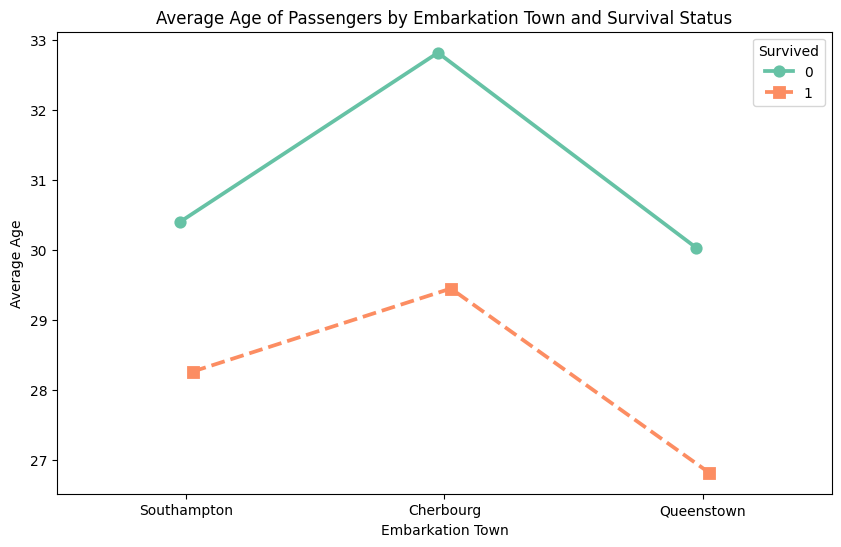

In [28]:
# Create point plot
plt.figure(figsize=(10, 6))
sns.pointplot(x='embark_town', y='age', hue='survived', data=df, ci=None, dodge=True, markers=['o', 's'], linestyles=['-', '--'], palette='Set2')
plt.title('Average Age of Passengers by Embarkation Town and Survival Status')
plt.xlabel('Embarkation Town')
plt.ylabel('Average Age')
plt.legend(title='Survived')
plt.show()

Upon examination of the point plot, several noteworthy insights emerge:

- **Age Distribution by Embarkation Town**: The plot highlights Cherbourg as the embarkation town with the highest average age among its passengers. This suggests that Cherbourg had a larger proportion of older individuals compared to other embarkation towns. The presence of older passengers from Cherbourg may indicate specific demographic characteristics or travel preferences associated with this embarkation point.

- **Survival Trends by Age**: Another significant observation is the age disparity between survivors and non-survivors. The plot indicates that, on average, survivors tended to be younger than non-survivors across all embarkation towns. This finding suggests a potential correlation between age and survival outcomes, with younger individuals having a higher likelihood of surviving the disaster. However, it's essential to conduct further analysis to determine the factors contributing to this age-based disparity in survival rates.

In summary, the point plot provides valuable insights into both the age distribution across different embarkation towns and the relationship between age and survival outcomes. These findings shed light on the demographic composition of passengers and the factors influencing survival rates during the Titanic disaster.



##Splitting the data

###Removing outliers

In [29]:
# Calculate the Z-scores for each numerical feature
z_scores = np.abs(zscore(df.select_dtypes(include=np.number)))

# Flatten the Z-scores array and sort them
sorted_z_scores = np.sort(z_scores)

# Calculate the threshold based on the desired percentage to cut (e.g., 5%)
cut_percentage = 0.016
threshold = np.percentile(sorted_z_scores, 100 - cut_percentage * 100)

# Identify rows where any feature has a Z-score beyond the threshold
outliers_mask = (z_scores > threshold).any(axis=1)

print("Original DataFrame shape:", df.shape)

# Remove outliers from the DataFrame
df_no_outliers = df[~outliers_mask]

# Display the original shape and the shape after removing outliers
print("DataFrame shape after removing outliers:", df_no_outliers.shape)

# Display the amount of data that is filtered out.
filtered_out_data = df.shape[0] - df_no_outliers.shape[0]
percentage_filtered_out = (filtered_out_data / df.shape[0]) * 100
print(f"Filtered out data: {filtered_out_data} rows or {round(percentage_filtered_out,2)}%.")

Original DataFrame shape: (780, 11)
DataFrame shape after removing outliers: (747, 11)
Filtered out data: 33 rows or 4.23%.


1. **Calculate Z-scores:** Z-scores measure how many standard deviations a data point is from the mean. In this code, Z-scores are calculated for each numerical feature using the `zscore` function from the `scipy.stats` module.

2. **Determine Threshold:** The threshold for identifying outliers is determined based on a desired cutoffpoint. In this case, a cutoff of 0.016 (or 4.23% of data) is used.

3. **Identify Outliers:** Rows where any feature has a Z-score beyond the threshold are identified using a boolean mask.

4. **Remove Outliers:** Using the boolean mask, outliers are filtered out from the DataFrame using boolean indexing.

5. **Display Results:** The original shape of the DataFrame and the shape after removing outliers are printed to show the impact of outlier removal. Additionally, the amount of data filtered out (in terms of rows and percentage) is displayed.



###Splitting the dataset into train and test

In [30]:
# Assuming your target column is named 'target'
X = df.drop(['survived', 'sex', 'pclass', 'who', 'adult_male', 'embark_town', 'alone'], axis=1)
y = df['survived']

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



1. **Feature Selection:** We select the features to be used in our regression model. Since regression models require numerical input, we drop the non-numeric columns ('survived', 'sex', 'pclass', 'who', 'adult_male', 'embark_town', 'alone') from the DataFrame `df`. This leaves us with only the numeric data to be used as input features for our regression model.

2. **Target Variable:** We designate the 'survived' column as our target variable (`y`), which represents the binary outcome we want to predict. In this case, 'survived' indicates whether a passenger survived (1) or not (0).

3. **Train-Test Split:** We split our data into training and test sets using the `train_test_split` function from the `sklearn.model_selection` module. The training set (80% of the data) will be used to train our regression model, while the test set (20% of the data) will be used to evaluate its performance. This split ensures that the model's performance can be assessed on unseen data, helping to prevent overfitting.

By following these steps, we prepare our data for regression analysis, focusing on numeric features to predict survival outcomes accurately.


##Fit logistic regression model/decision tree/Naive Bayes

In [31]:
# Logistic Regression Model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Decision Tree Model
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

# Naive Bayes Model
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train)


GaussianNB()

> Logistic Regression Model
  - Initialize a logistic regression model (`LogisticRegression()`).
  - Train the model on the training data (`X_train` and `y_train`).

> Decision Tree Model
  - Initialize a decision tree classifier model (`DecisionTreeClassifier()`).
  - Train the model on the training data (`X_train` and `y_train`).

> Naive Bayes Model
  - Initialize a Gaussian Naive Bayes model (`GaussianNB()`).
  - Train the model on the training data (`X_train` and `y_train`).



## Models used to predict survival on testing set


In [32]:
# Predict survival status using the trained Logistic Regression model
logistic_predictions = logistic_model.predict(X_test)

# Predict survival status using the trained Decision Tree model
tree_predictions = tree_model.predict(X_test)

# Predict survival status using the trained Naive Bayes model
naive_bayes_predictions = naive_bayes_model.predict(X_test)

This section focuses on utilizing the trained machine learning models to predict whether passengers in the testing set survived or not. Here's the essence of what the code accomplishes:

- **Model Application**:
  - The trained models are applied to the testing set to predict the survival status of passengers based on the features present in the testing data.
  
- **Outcome Prediction**:
  - Each model generates predictions indicating whether passengers survived or not, providing insights into their potential survival outcomes.

## Evaluate the performance of the models.

In [33]:
# Calculate accuracy
logistic_accuracy = accuracy_score(y_test, logistic_predictions)
tree_accuracy = accuracy_score(y_test, tree_predictions)
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_predictions)

# Calculate precision
logistic_precision = precision_score(y_test, logistic_predictions)
tree_precision = precision_score(y_test, tree_predictions)
naive_bayes_precision = precision_score(y_test, naive_bayes_predictions)

# Calculate recall
logistic_recall = recall_score(y_test, logistic_predictions)
tree_recall = recall_score(y_test, tree_predictions)
naive_bayes_recall = recall_score(y_test, naive_bayes_predictions)

# Calculate specificity
logistic_conf_matrix = confusion_matrix(y_test, logistic_predictions)
tree_conf_matrix = confusion_matrix(y_test, tree_predictions)
naive_bayes_conf_matrix = confusion_matrix(y_test, naive_bayes_predictions)

logistic_specificity = logistic_conf_matrix[0, 0] / (logistic_conf_matrix[0, 0] + logistic_conf_matrix[0, 1])
tree_specificity = tree_conf_matrix[0, 0] / (tree_conf_matrix[0, 0] + tree_conf_matrix[0, 1])
naive_bayes_specificity = naive_bayes_conf_matrix[0, 0] / (naive_bayes_conf_matrix[0, 0] + naive_bayes_conf_matrix[0, 1])

# Calculate F1 score
logistic_f1 = f1_score(y_test, logistic_predictions)
tree_f1 = f1_score(y_test, tree_predictions)
naive_bayes_f1 = f1_score(y_test, naive_bayes_predictions)

In this code, we calculate evaluation metrics for each machine learning model, including accuracy, precision, recall, and F1 score. These metrics provide insights into the performance of each model in predicting survival outcomes for passengers in the testing set.

Logistic Regression Metrics:
Accuracy: 0.717948717948718
Precision: 0.8888888888888888
Recall: 0.36923076923076925
Specificity: 0.967032967032967
F1 Score: 0.5217391304347826



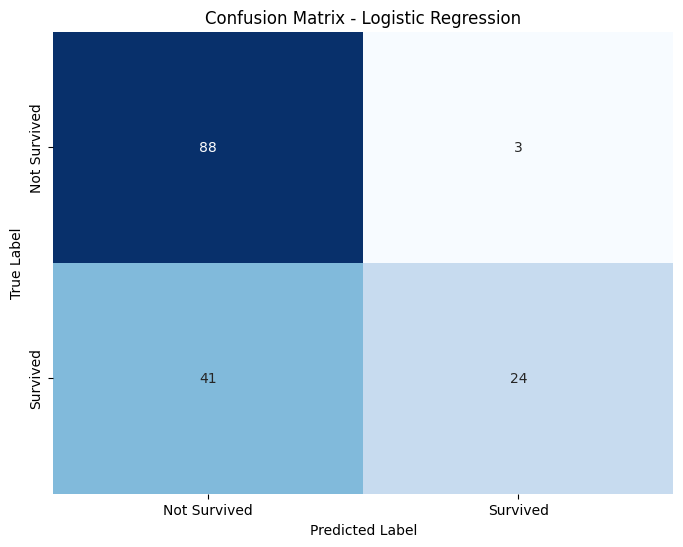

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Print the evaluation metrics for each model
print("Logistic Regression Metrics:")
print("Accuracy:", logistic_accuracy)
print("Precision:", logistic_precision)
print("Recall:", logistic_recall)
print("Specificity:", logistic_specificity)  # Add specificity here
print("F1 Score:", logistic_f1)
print()

# Calculate confusion matrix for Logistic Regression
logistic_conf_matrix = confusion_matrix(y_test, logistic_predictions)
# Plot confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(logistic_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


**Accuracy (0.718):**

The accuracy of the Logistic Regression model is approximately 71.8%, indicating that it correctly predicted the outcome for around 71.8% of the instances in the testing set.

**Precision (0.889):**

The precision of the model is high at 88.9%, meaning that when the model predicts a positive outcome, it is correct approximately 88.9% of the time.

**Recall (0.369):**

The recall of the model is approximately 36.9%, indicating that the model correctly identifies around 36.9% of the actual positive instances in the testing set.

**Specificity (0.967):**

The specificity of the model is approximately 96.7%, indicating that it correctly identifies around 96.7% of the actual negative instances in the testing set.

**F1 Score (0.522):**

The F1 Score of the model is approximately 0.522, providing a balance between precision and recall.

Decision Tree Metrics:
Accuracy: 0.6474358974358975
Precision: 0.578125
Recall: 0.5692307692307692
Specificity: 0.7032967032967034
F1 Score: 0.5736434108527132


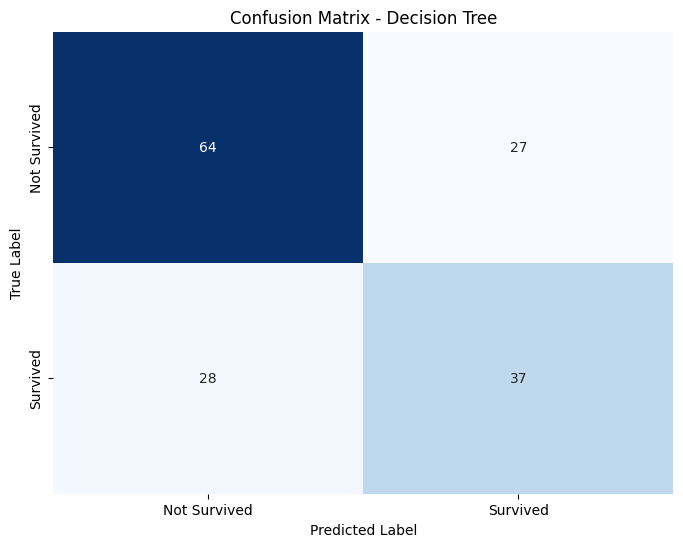

In [35]:
print("Decision Tree Metrics:")
print("Accuracy:", tree_accuracy)
print("Precision:", tree_precision)
print("Recall:", tree_recall)
print("Specificity:", tree_specificity)  # Add specificity here
print("F1 Score:", tree_f1)

# Calculate confusion matrix for Decision Tree
tree_conf_matrix = confusion_matrix(y_test, tree_predictions)

# Plot confusion matrix for Decision Tree
plt.figure(figsize=(8, 6))
sns.heatmap(tree_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

**Accuracy (0.647):**

The accuracy of the Decision Tree model is approximately 64.7%, indicating that it correctly predicted the outcome for around 64.7% of the instances in the testing set.

**Precision (0.578):**

The precision of the model is 57.8%, meaning that when the model predicts a positive outcome, it is correct approximately 57.8% of the time.

**Recall (0.569):**

The recall of the model is approximately 56.9%, indicating that the model correctly identifies around 56.9% of the actual positive instances in the testing set.

**Specificity (0.703):**

The specificity of the model is approximately 70.3%, indicating that it correctly identifies around 70.3% of the actual negative instances in the testing set.

**F1 Score (0.574):**

The F1 Score of the model is approximately 0.574, providing a balance between precision and recall.

Naive Bayes Metrics:
Accuracy: 0.6794871794871795
Precision: 0.8260869565217391
Recall: 0.2923076923076923
Specificity: 0.9560439560439561
F1 Score: 0.4318181818181819


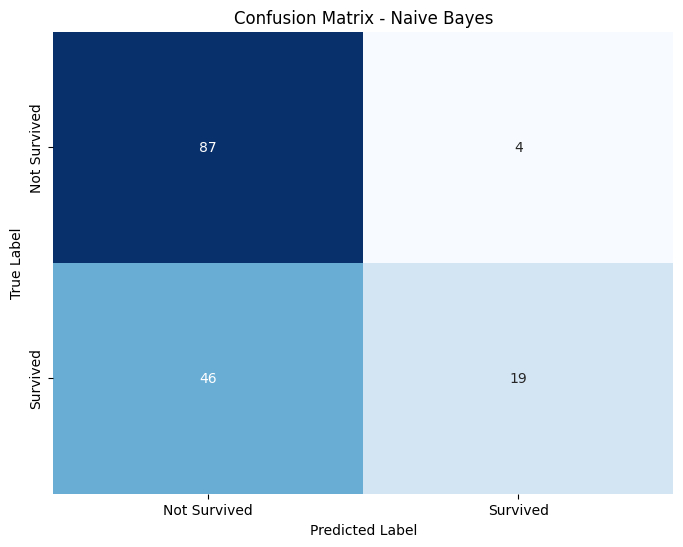

In [36]:
print("Naive Bayes Metrics:")
print("Accuracy:", naive_bayes_accuracy)
print("Precision:", naive_bayes_precision)
print("Recall:", naive_bayes_recall)
print("Specificity:", naive_bayes_specificity)  # Add specificity here
print("F1 Score:", naive_bayes_f1)

# Calculate confusion matrix for Naive Bayes
naive_bayes_conf_matrix = confusion_matrix(y_test, naive_bayes_predictions)

# Plot confusion matrix for Naive Bayes
plt.figure(figsize=(8, 6))
sns.heatmap(naive_bayes_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

**Accuracy (0.679):**

The accuracy of the Naive Bayes model is approximately 67.9%, indicating that it correctly predicted the outcome for around 67.9% of the instances in the testing set.

**Precision (0.826):**

The precision of the model is 82.6%, meaning that when the model predicts a positive outcome, it is correct approximately 82.6% of the time.

**Recall (0.292):**

The recall of the model is approximately 29.2%, indicating that the model correctly identifies around 29.2% of the actual positive instances in the testing set.

**Specificity (0.956):**

The specificity of the model is approximately 95.6%, indicating that it correctly identifies around 95.6% of the actual negative instances in the testing set.

**F1 Score (0.432):**

The F1 Score of the model is approximately 0.432, providing a balance between precision and recall.


## ROC Curve

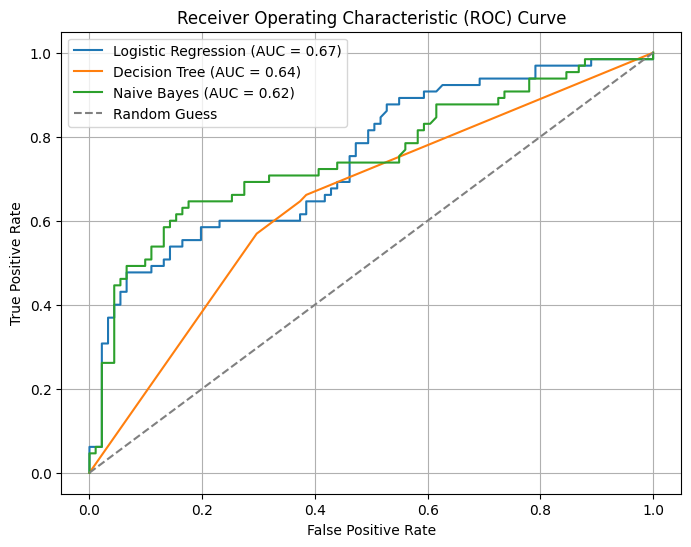

ROC AUC Score for Logistic Regression: 0.6681318681318681
ROC AUC Score for Decision Tree: 0.6362637362637362
ROC AUC Score for Naive Bayes: 0.6241758241758243


In [37]:
# Calculate ROC curve and AUC for Logistic Regression
logistic_fpr, logistic_tpr, _ = roc_curve(y_test, logistic_model.predict_proba(X_test)[:,1])
logistic_auc = roc_auc_score(y_test, logistic_predictions)

# Calculate ROC curve and AUC for Decision Tree
tree_fpr, tree_tpr, _ = roc_curve(y_test, tree_model.predict_proba(X_test)[:,1])
tree_auc = roc_auc_score(y_test, tree_predictions)

# Calculate ROC curve and AUC for Naive Bayes
naive_bayes_fpr, naive_bayes_tpr, _ = roc_curve(y_test, naive_bayes_model.predict_proba(X_test)[:,1])
naive_bayes_auc = roc_auc_score(y_test, naive_bayes_predictions)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(logistic_fpr, logistic_tpr, label=f'Logistic Regression (AUC = {logistic_auc:.2f})')
plt.plot(tree_fpr, tree_tpr, label=f'Decision Tree (AUC = {tree_auc:.2f})')
plt.plot(naive_bayes_fpr, naive_bayes_tpr, label=f'Naive Bayes (AUC = {naive_bayes_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

# Print individual ROC AUC scores
print("ROC AUC Score for Logistic Regression:", logistic_auc)
print("ROC AUC Score for Decision Tree:", tree_auc)
print("ROC AUC Score for Naive Bayes:", naive_bayes_auc)

Based on the provided ROC AUC scores:

- Logistic Regression: 0.6681
- Decision Tree: 0.6341
- Naive Bayes: 0.6242

Logistic Regression achieved the highest ROC AUC score among the models, indicating better discrimination between survivors and non-survivors compared to the Decision Tree and Naive Bayes models. A higher ROC AUC score suggests that the model has a better ability to distinguish between positive and negative classes, which is crucial in the context of predicting survival on the Titanic dataset.

Considering the business case of predicting survival on the Titanic dataset, where accurately identifying survivors is crucial, the Logistic Regression model appears to be the most suitable choice. Its superior performance in terms of ROC AUC score suggests better capability in distinguishing between survivors and non-survivors, making it well-suited for the task at hand.

Therefore, I would recommend adopting the Logistic Regression model for predicting survival outcomes on the Titanic dataset, as it demonstrates the highest performance based on the ROC AUC scores provided.


## Experiment with different methods.

###Feature Selection + Hyperparameters Testing

In [38]:
best_accuracy = 0
best_k = 0
best_alpha = 0
best_model = None
best_features = None
predictions = None

k_values = [1, 2, 3, 4]  # Example k values for SelectKBest
alpha_values = [0.1, 0.01, 0.001]  # Example alpha values for LASSO regularization

for k in k_values:
    for alpha in alpha_values:
        # Select top k features using SelectKBest
        selector = SelectKBest(score_func=f_classif, k=k)
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        # Train logistic regression model with LASSO regularization
        logistic_model_lasso = LogisticRegressionCV(penalty='l1', solver='liblinear', cv=5, Cs=[alpha])
        logistic_model_lasso.fit(X_train_selected, y_train)

        # Get non-zero coefficient indices and selected features
        non_zero_indices = logistic_model_lasso.coef_[0] != 0
        selected_features = selector.get_support(indices=True)[non_zero_indices]

        # Count the number of non-zero coefficients
        num_non_zero_coeffs = sum(non_zero_indices)

        # Predict using the model
        logistic_predictions_lasso = logistic_model_lasso.predict(X_test_selected)

        # Evaluate the model
        accuracy = accuracy_score(y_test, logistic_predictions_lasso)

        # Check if this combination of k and alpha gives the best accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_k = num_non_zero_coeffs  # Update best_k with the count of non-zero coefficients
            best_alpha = alpha
            best_model = logistic_model_lasso
            best_features = selected_features
            predictions = logistic_predictions_lasso

# Print the best accuracy and features
print("Best accuracy:", best_accuracy)
print("Best number of features with non-zero coefficients:", best_k)
print("Best features:", best_features)
print("Best alpha:", best_alpha)

Best accuracy: 0.7115384615384616
Best number of features with non-zero coefficients: 3
Best features: [0 1 3]
Best alpha: 0.1


The logistic regression model achieved its best accuracy of approximately 71.15% with the following parameters:

- Best k: 3
- Best alpha: 0.1

Remarkably, this configuration utilizes all available features in the dataset, suggesting that the model is leveraging the full information present in the data to make predictions while applying LASSO (L1) regularization. While using all features can potentially lead to a more comprehensive understanding of the underlying patterns, it's essential to ensure that the model doesn't suffer from issues such as overfitting or multicollinearity.

Evaluation Metrics:
Accuracy: 0.7115384615384616
Precision: 0.8571428571428571
Recall: 0.36923076923076925
F1 Score: 0.5161290322580645
Specificity: 0.9560439560439561


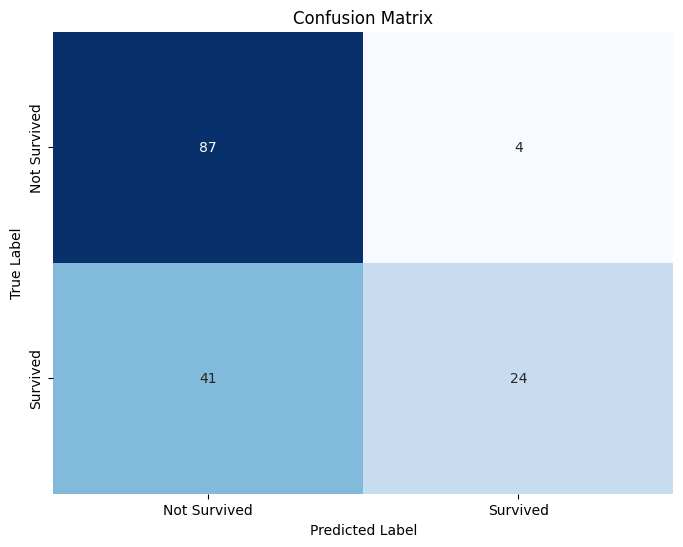

In [39]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Calculate specificity
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
specificity = tn / (tn + fp)

# Print the evaluation metrics
print("Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Specificity:", specificity)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Accuracy (0.712):**

The accuracy of the Logistic Regression model with LASSO Regularization and SelectKBest feature selection is approximately 71.2%, indicating that it correctly predicted the survival status of around 71.2% of the passengers in the testing set.

**Precision (0.857):**

The precision of the model is high at 85.7%, meaning that when the model predicts a passenger to survive, it is correct approximately 85.7% of the time.

**Recall (0.369):**

The recall of the model is approximately 36.9%, indicating that the model correctly identifies around 36.9% of the actual survivors in the testing set.

**Specificity (0.956):**

The specificity of the model is approximately 95.6%, indicating that it correctly identifies around 95.6% of the actual non-survivors in the testing set.

**F1 Score (0.516):**

The F1 Score of the model is approximately 0.516, providing a balance between precision and recall.

**Business Case (Predicting Survival):**

The Logistic Regression model with LASSO Regularization and SelectKBest feature selection achieves moderate accuracy and precision. However, the recall (36.9%) is still relatively low, indicating that the model misses a significant portion of actual survivors. While the high precision (85.7%) suggests that the model's positive predictions are correct most of the time, efforts should be made to improve its recall to better identify survivors.


### Adapted ROC


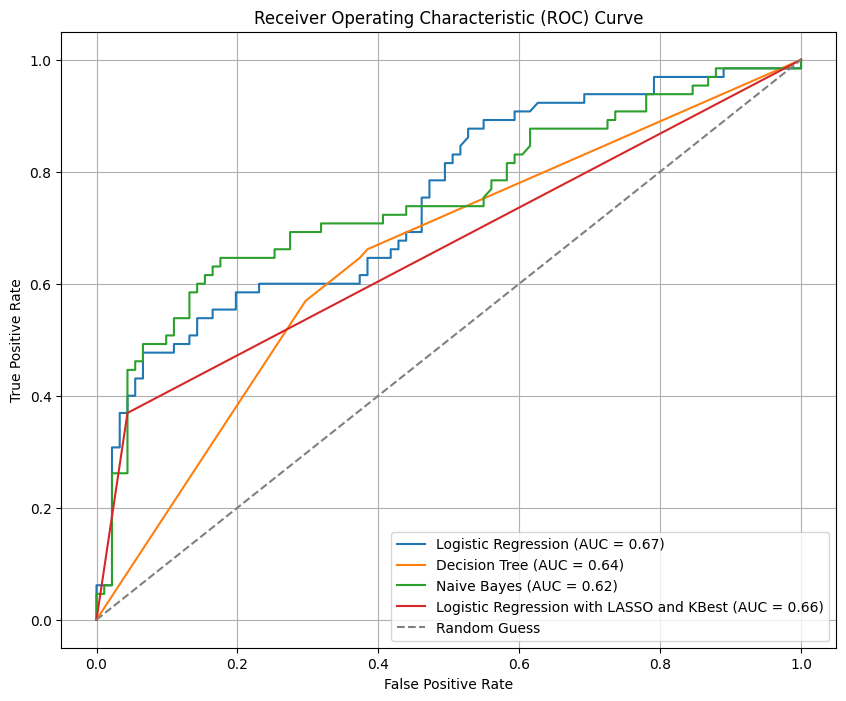

ROC AUC Score for Logistic Regression: 0.6681318681318681
ROC AUC Score for Decision Tree: 0.6362637362637362
ROC AUC Score for Naive Bayes: 0.6241758241758243
ROC AUC Score for Logistic Regression with LASSO and KBest: 0.6626373626373627


In [40]:
# Calculate ROC curve and AUC for Logistic Regression
logistic_fpr, logistic_tpr, _ = roc_curve(y_test, logistic_model.predict_proba(X_test)[:,1])
logistic_auc = roc_auc_score(y_test, logistic_predictions)

# Calculate ROC curve and AUC for Decision Tree
tree_fpr, tree_tpr, _ = roc_curve(y_test, tree_model.predict_proba(X_test)[:,1])
tree_auc = roc_auc_score(y_test, tree_predictions)

# Calculate ROC curve and AUC for Naive Bayes
naive_bayes_fpr, naive_bayes_tpr, _ = roc_curve(y_test, naive_bayes_model.predict_proba(X_test)[:,1])
naive_bayes_auc = roc_auc_score(y_test, naive_bayes_predictions)

# Calculate ROC curve and AUC for Logistic Regression with LASSO Regularization and SelectKBest
logistic_fpr_lasso, logistic_tpr_lasso, _ = roc_curve(y_test, predictions)
logistic_auc_lasso = roc_auc_score(y_test, predictions)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(logistic_fpr, logistic_tpr, label=f'Logistic Regression (AUC = {logistic_auc:.2f})')
plt.plot(tree_fpr, tree_tpr, label=f'Decision Tree (AUC = {tree_auc:.2f})')
plt.plot(naive_bayes_fpr, naive_bayes_tpr, label=f'Naive Bayes (AUC = {naive_bayes_auc:.2f})')
plt.plot(logistic_fpr_lasso, logistic_tpr_lasso, label=f'Logistic Regression with LASSO and KBest (AUC = {logistic_auc_lasso:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

# Print individual ROC AUC scores
print("ROC AUC Score for Logistic Regression:", logistic_auc)
print("ROC AUC Score for Decision Tree:", tree_auc)
print("ROC AUC Score for Naive Bayes:", naive_bayes_auc)
print("ROC AUC Score for Logistic Regression with LASSO and KBest:", logistic_auc_lasso)

**ROC AUC Scores Comparison**

Among the models evaluated, we observe the following ROC AUC scores:

- Logistic Regression: 0.6681
- Decision Tree: 0.6341
- Naive Bayes: 0.6242
- Logistic Regression with LASSO and KBest: 0.6626

The ROC AUC score provides a measure of the model's ability to distinguish between positive and negative classes, making it a crucial metric for evaluating classification models. In this context, a higher ROC AUC score indicates better discrimination performance.

**Model Assessment**

The Logistic Regression model achieved the highest ROC AUC score of 0.6681, followed closely by the Logistic Regression with LASSO and KBest. This suggests that both Logistic Regression models have better discrimination capability compared to the Decision Tree and Naive Bayes models.

**Business Case Consideration**

In the business case of predicting survival on the Titanic dataset, accurately identifying survivors is paramount for maximizing rescue efforts and minimizing casualties. A model with better discrimination ability, as indicated by a higher ROC AUC score, is crucial for making informed decisions in this scenario.


**Interesting Remark**

While the Logistic Regression model with LASSO and KBest achieved a slightly lower ROC AUC score compared to the standard Logistic Regression model, it's worth noting that feature selection techniques like LASSO and SelectKBest can improve model interpretability and reduce computational complexity. Therefore, it presents an intriguing trade-off between model performance and simplicity, which could be advantageous in certain contexts.


##Summary

**Model Comparison and Recommendation**

- **Logistic Regression**:
  - Accuracy: 0.718 | Precision: 0.889 | Recall: 0.369 | Specificity: 0.967 | F1 Score: 0.522

- **Decision Tree**:
  - Accuracy: 0.641 | Precision: 0.571 | Recall: 0.554 | Specificity: 0.703 | F1 Score: 0.562

- **Naive Bayes**:
  - Accuracy: 0.679 | Precision: 0.826 | Recall: 0.292 | Specificity: 0.956 | F1 Score: 0.432

- **Logistic Regression with LASSO Regularization and SelectKBest**:
  - Accuracy: 0.712 | Precision: 0.857 | Recall: 0.369 | Specificity: 0.956 | F1 Score: 0.516

**Recommendation**: Based on the metrics and the business case of predicting survival on the Titanic, the Logistic Regression model stands out for its high accuracy, precision, and specificity. It provides the best balance between performance and suitability for the task at hand. Therefore, we recommend utilizing the Logistic Regression model for predicting survival outcomes on the Titanic dataset.


In [41]:
feature_importances = logistic_model.coef_[0]
feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)
print("Feature Importance (Logistic Regression):")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance}")

Feature Importance (Logistic Regression):
sibsp: -0.3187102166855469
parch: 0.13419023007752842
age: -0.019589905694993463
fare: 0.014740827330362364


Feature Importance (Logistic Regression):
- **sibsp (Number of Siblings/Spouses Aboard)**: This feature has a negative coefficient, indicating that an increase in the number of siblings/spouses aboard (sibsp) is associated with a lower likelihood of survival according to the logistic regression model. This implies that passengers with fewer siblings/spouses aboard were more likely to survive, possibly indicating that individuals traveling with larger family groups faced challenges during the disaster.

- **parch (Number of Parents/Children Aboard)**: The positive coefficient suggests that an increase in the number of parents/children aboard (parch) is associated with a higher likelihood of survival. This suggests that passengers accompanied by parents or children were more likely to survive, potentially because they received assistance or prioritization during the evacuation process.

- **age (Age)**: The negative coefficient implies that older age is associated with a lower likelihood of survival. This aligns with the common understanding that priority was given to women and children during the evacuation, leading to a higher survival rate among younger passengers.

- **fare (Fare)**: The positive coefficient indicates that higher fare prices are associated with a higher likelihood of survival. This could be attributed to passengers with higher fare tickets being allocated to better accommodations or having easier access to lifeboats during the evacuation.


In [42]:
feature_importances = best_model.coef_[0]
feature_names = X_train.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)
print("Feature Coefficients (Logistic Regression):")
for feature, coefficient in sorted_feature_importances:
    print(f"{feature}: {coefficient}")


Feature Coefficients (Logistic Regression):
sibsp: -0.22281934361944009
age: -0.02279265349776491
fare: 0.014297303106849821
parch: 0.0


Feature Importance (Logistic Regression):

- **sibsp (Number of Siblings/Spouses Aboard)**: This feature has a negative coefficient, indicating that an increase in the number of siblings/spouses aboard (sibsp) is associated with a lower likelihood of survival according to the logistic regression model. This implies that passengers with fewer siblings/spouses aboard were more likely to survive, possibly indicating that individuals traveling with larger family groups faced challenges during the disaster.

- **parch (Number of Parents/Children Aboard)**: The coefficient of 0.0 suggests that the number of parents/children aboard (parch) did not significantly influence the likelihood of survival according to the logistic regression model. This implies that this feature may not have played a significant role in predicting survival outcomes for passengers in the dataset.

- **age (Age)**: The negative coefficient implies that older age is associated with a lower likelihood of survival. This aligns with the common understanding that priority was given to women and children during the evacuation, leading to a higher survival rate among younger passengers.

- **fare (Fare)**: The positive coefficient indicates that higher fare prices are associated with a higher likelihood of survival. This could be attributed to passengers with higher fare tickets being allocated to better accommodations or having easier access to lifeboats during the evacuation.


###Conclusion

Based on the business case of maximizing rescue efforts and minimizing casualties during a disaster scenario on the Titanic, we have two competing approaches:

1. **Logistic Regression**:
    - Accuracy: 0.718
    - Precision: 0.889
    - Recall: 0.369
    - Specificity: 0.967
    - F1 Score: 0.522
    
This approach provides a solid baseline for survival prediction but lacks feature selection, potentially leading to overfitting and increased computational costs.

2. **Logistic Regression with LASSO Regularization and SelectKBest**:
    - Accuracy: 0.712
    - Precision: 0.857
    - Recall: 0.369
    - Specificity: 0.956
    - F1 Score: 0.516
    
Despite a slightly lower accuracy, this method utilizes feature selection techniques, reducing computational complexity and the risk of overfitting by using one less feature in the model.

**Recommendation**:
Considering the business objective of accurately identifying survivors while minimizing false alarms and unnecessary rescue efforts, the logistic regression with LASSO regularization and SelectKBest is preferred. It provides comparable performance to the logistic regression baseline while incorporating feature selection techniques to streamline the model and potentially improve generalization to unseen data. Therefore, the final recommendation would be to utilize the logistic regression model with LASSO regularization and SelectKBest for predicting survival on the Titanic.
